

# 1. Importing tools



In [1]:
!pip install torch torchvision torchaudio pandas numpy scikit-learn matplotlib

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 2. Load the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
df = pd.read_csv('/content/drive/MyDrive/eeg_focus_dataset.csv')

print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (3690, 7)
    channel_1   channel_2   channel_3   channel_4  beta_power  focus_score  \
0  175.393361  -37.061474 -219.349340 -341.066254         0.0          0.0   
1 -617.531813 -528.925168 -355.958068 -327.035552         0.0          0.0   
2  -76.964804  -97.501529  -87.215869  -82.217493         0.0          0.0   
3  637.646398  635.192088  867.811528  899.621247         0.0          0.0   
4  901.929700  843.210466  879.257492  880.299054         0.0          0.0   

   focused_classification  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  


In [23]:
# Parameters
n_channels = 4
window_size = 250  # number of samples per window (1s at 250Hz)
step_size = 25    # overlap half window

X = []
y = []

data = df[['channel_1', 'channel_2', 'channel_3', 'channel_4']].values
labels = df['focused_classification'].values

for start in range(0, len(data) - window_size, step_size):
    end = start + window_size
    X.append(data[start:end].T)   # shape (4, window_size)
    # Majority label in window (optional)
    y.append(int(labels[start:end].mean() > 0.5))

X = np.array(X)
y = np.array(y)

def augment(X, noise_std=0.01):
    return X + np.random.randn(*X.shape) * noise_std
X_aug = augment(X)
X = np.concatenate([X, X_aug])
y = np.concatenate([y, y])


print("Shape:", X.shape, y.shape)

Shape: (276, 4, 250) (276,)


# 3. Preprocessing the dataset

In [34]:
scaler = StandardScaler()
X_reshaped = X.transpose(0, 2, 1).reshape(-1, n_channels)
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(-1, window_size, n_channels).transpose(0, 2, 1)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=32, shuffle=True)
val_loader = DataLoader(list(zip(X_val, y_val)), batch_size=32)

# 4. Defining CNN model

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class EEGNet(nn.Module):
    def __init__(self, n_channels=4, n_timepoints=250):
        super(EEGNet, self).__init__()
        self.n_channels = n_channels
        self.n_timepoints = n_timepoints

        # Temporal Convolution
        self.conv1 = nn.Conv2d(1, 16, (1, 64), padding=(0, 32), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(16)

        # Depthwise Convolution
        self.depthwise = nn.Conv2d(16, 32, (n_channels, 1), groups=16, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.pooling2 = nn.AvgPool2d((1, 4))
        self.dropout2 = nn.Dropout(0.5)

        # Separable Convolution
        self.separable = nn.Conv2d(32, 32, (1, 16), padding=(0, 8), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.pooling3 = nn.AvgPool2d((1, 8))
        self.dropout3 = nn.Dropout(0.5)

        # Fully Connected (output)
        # This depends on timepoints and pooling size
        self.output_size = self._get_output_size()
        self.fc1 = nn.Linear(self.output_size, 1)

    def _get_output_size(self):
        # Simulate forward pass to compute flattened size
        x = torch.zeros(1, 1, self.n_channels, self.n_timepoints)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.elu(x)
        x = self.depthwise(x)
        x = self.batchnorm2(x)
        x = F.elu(x)
        x = self.pooling2(x)
        x = self.dropout2(x)
        x = self.separable(x)
        x = self.batchnorm3(x)
        x = F.elu(x)
        x = self.pooling3(x)
        x = self.dropout3(x)
        return x.view(1, -1).shape[1]

    def forward(self, x):
        x = F.elu(self.batchnorm1(self.conv1(x)))
        x = F.elu(self.batchnorm2(self.depthwise(x)))
        x = self.pooling2(x)
        x = self.dropout2(x)
        x = F.elu(self.batchnorm3(self.separable(x)))
        x = self.pooling3(x)
        x = self.dropout3(x)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        return x


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGNet(n_channels=4, n_timepoints=250).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 5. Training Loop

In [42]:
EPOCHS = 40
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            val_loss += criterion(preds, yb).item()
            predicted_labels = (preds > 0.5).float()
            correct += (predicted_labels == yb).sum().item()

    acc = correct / len(X_val)
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{EPOCHS}: Train {train_losses[-1]:.4f}, Val {val_losses[-1]:.4f}, Acc {acc:.2%}")

Epoch 1/40: Train 0.6100, Val 0.6301, Acc 71.43%
Epoch 2/40: Train 0.4982, Val 0.6052, Acc 71.43%
Epoch 3/40: Train 0.4512, Val 0.5984, Acc 71.43%
Epoch 4/40: Train 0.4096, Val 0.5874, Acc 73.21%
Epoch 5/40: Train 0.3542, Val 0.5832, Acc 73.21%
Epoch 6/40: Train 0.3349, Val 0.5783, Acc 71.43%
Epoch 7/40: Train 0.2877, Val 0.5687, Acc 71.43%
Epoch 8/40: Train 0.2797, Val 0.5520, Acc 73.21%
Epoch 9/40: Train 0.2641, Val 0.5027, Acc 76.79%
Epoch 10/40: Train 0.2273, Val 0.4437, Acc 82.14%
Epoch 11/40: Train 0.2277, Val 0.3353, Acc 87.50%
Epoch 12/40: Train 0.2110, Val 0.2898, Acc 87.50%
Epoch 13/40: Train 0.1785, Val 0.3073, Acc 87.50%
Epoch 14/40: Train 0.2078, Val 0.2999, Acc 87.50%
Epoch 15/40: Train 0.2127, Val 0.2303, Acc 92.86%
Epoch 16/40: Train 0.1670, Val 0.3119, Acc 85.71%
Epoch 17/40: Train 0.1565, Val 0.2400, Acc 94.64%
Epoch 18/40: Train 0.1894, Val 0.2229, Acc 87.50%
Epoch 19/40: Train 0.1482, Val 0.4052, Acc 83.93%
Epoch 20/40: Train 0.2118, Val 0.3157, Acc 85.71%
Epoch 21/

# 6. Plotting graphs

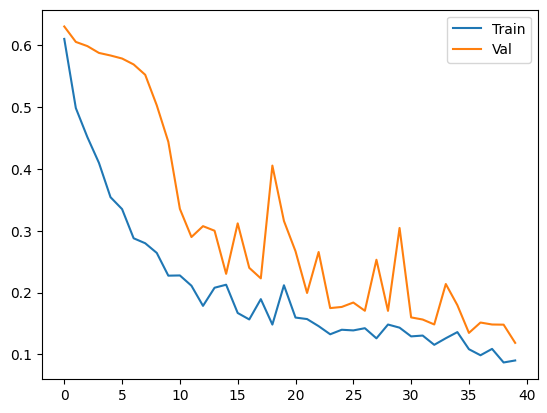

In [43]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.legend()
plt.show()

In [44]:
from sklearn.metrics import confusion_matrix, classification_report

model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculations
    y_pred = model(X_val.to(device)) # Get predictions for the entire validation set

# Move predictions and true labels to CPU for sklearn functions
y_pred_cpu = y_pred.cpu().numpy()
y_val_cpu = y_val.cpu().numpy()

preds = (y_pred_cpu > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_val_cpu, preds))
print("\nClassification Report:")
print(classification_report(y_val_cpu, preds))

Confusion Matrix:
[[18  0]
 [ 1 37]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97        18
         1.0       1.00      0.97      0.99        38

    accuracy                           0.98        56
   macro avg       0.97      0.99      0.98        56
weighted avg       0.98      0.98      0.98        56



# 7. Saving the model

In [45]:
torch.save(model.state_dict(), "focus_eegnet_4ch.pth")
print("Model saved as focus_eegnet_4ch.pth")

Model saved as focus_eegnet_4ch.pth


In [47]:
from google.colab import files
files.download("focus_eegnet_4ch.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>